In [71]:
import importlib
import sys
import csv
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import json
import re
from pathlib import Path
from functools import reduce
import networkx as nx
from collections import defaultdict
import random
from itertools import combinations  
import math
from scipy import stats
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

sys.path.insert(0, '/Documents/calciumAnalysis/codes/python/')

import functions as my
importlib.reload(my)


# edges_list: list of M dataframes, each with ['source', 'target', 'weight']
# Example: edges_list = [df0, df1, df2, ...] for M recordings
def combine_edges(edges_list):
    combined_df = None
    for i, df in enumerate(edges_list):
        df = df.copy()
        df = df[['source', 'target', 'weight']].dropna()
        df.rename(columns={'weight': f'weight_{i}'}, inplace=True)
        if combined_df is None:
            combined_df = df
        else:
            combined_df = pd.merge(combined_df, df, on=['source', 'target'], how='outer')
    
    return combined_df


def combine_nodes(nodes_list):
    activation_frames = []
    
    for i, df in enumerate(nodes_list):
        df = df.copy()
        df.rename(columns={'activations': f'activations_{i}'}, inplace=True)
        activation_frames.append(df[['names', f'activations_{i}']])
    
    # Merge activations across all recordings
    from functools import reduce
    
    merged_activations = reduce(
        lambda left, right: pd.merge(left, right, on='names', how='outer'),
        activation_frames
    )
    
    # Compute average posx, posy, and area
    # (Assuming nodes_list all have same 'name' order and content)
    positions = pd.concat([df[['names', 'posx', 'posy', 'area']] for df in nodes_list])
    avg_positions = (
        positions.groupby('names', as_index=False)
        .mean()
        .rename(columns={'posx': 'avg_posx', 'posy': 'avg_posy', 'area': 'avg_area'})
    )
    
    # Merge averages and activations
    combined_nodes_df = pd.merge(avg_positions, merged_activations, on='names')
    return combined_nodes_df
    # Optional: if you want a cleaner structure, fill NaNs with 0s (or keep NaNs if that matters)
    # combined_df = combined_df.fillna(0)

# Start with identifying metadata columns
def group_nodes_by_label(combined_nodes_df, label):

    # Group column indices by label
    label_to_indices = defaultdict(list)
    for i, label_val in enumerate(label):
        label_to_indices[label_val].append(i)
    
    node_metadata = combined_nodes_df[['names', 'avg_posx', 'avg_posy', 'avg_area']]
    
    # Group activations
    node_condition_dfs = []
    for condition, indices in label_to_indices.items():
        
        cols = [f'activations_{i}' for i in indices]
        # Compute row-wise mean
        mean_activation = combined_nodes_df[cols].mean(axis=1)
        condition_df = node_metadata.copy()
        condition_df[f'mean_activation_{condition}'] = mean_activation
        node_condition_dfs.append(condition_df[['names', f'mean_activation_{condition}']])
    
    # Merge all condition-specific activations
    grouped_nodes_df = reduce(lambda left, right: pd.merge(left, right, on='names'), node_condition_dfs)
    
    # Add metadata back
    grouped_nodes_df = pd.merge(node_metadata, grouped_nodes_df, on='names')

    return grouped_nodes_df

def groupe_edges_by_label(combined_edges_df, label):
    # Group column indices by label
    label_to_indices = defaultdict(list)
    for i, label_val in enumerate(label):
        label_to_indices[label_val].append(i)
    
    # Metadata
    edge_metadata = combined_edges_df[['source', 'target']]
    
    # Group weights
    edge_condition_dfs = []
    for condition, indices in label_to_indices.items():
        cols = [f'weight_{i}' for i in indices if f'weight_{i}' in combined_edges_df.columns]
        mean_weight = combined_edges_df[cols].mean(axis=1)
        condition_df = edge_metadata.copy()
        condition_df[f'mean_weight_{condition}'] = mean_weight
        edge_condition_dfs.append(condition_df[['source', 'target', f'mean_weight_{condition}']])
    
    # Merge all condition-specific weights
    grouped_edges_df = reduce(
        lambda left, right: pd.merge(left, right, on=['source', 'target'], how='outer'),
        edge_condition_dfs
    )
    return grouped_edges_df



def average_graphs_by_condition(graphs, labels):
    condition_groups = defaultdict(list)
    for G in graphs:
        condition = G.graph['condition']
        condition_groups[condition].append(G)

    averaged_graphs = {}

    for condition, group in condition_groups.items():
 
        # Create new graph
        G_avg = nx.DiGraph()
        G_avg.graph['condition'] = condition

        # --- Nodes ---
        all_nodes = set().union(*[G.nodes for G in group])
        for node in all_nodes:
            attrs = defaultdict(list)
            for G in group:
                if node in G:
                    for attr in ['activation', 'area']:
                        if attr in G.nodes[node]:
                            attrs[attr].append(G.nodes[node][attr])
                    if 'pos' in G.nodes[node]:
                        attrs['posx'].append(G.nodes[node]['pos'][0])
                        attrs['posy'].append(G.nodes[node]['pos'][1])
            
            if attrs:
                avg_activation = np.mean(attrs['activation']) if attrs['activation'] else 0
                avg_area = np.mean(attrs['area']) if attrs['area'] else 0
                #avg_posx = np.mean(attrs['posx']) if attrs['posx'] else 0
                #avg_posy = np.mean(attrs['posy']) if attrs['posy'] else 0
                if attrs['posx'] and attrs['posy']:
                    avg_pos = (np.mean(attrs['posx']), np.mean(attrs['posy']))
                else:
                    avg_pos = (0, 0)  # or np.nan, or skip the node entirely
                G_avg.add_node(node, activation=avg_activation, area=avg_area, pos=avg_pos)#(avg_posx, avg_posy))

        # --- Edges ---
        edge_weights = defaultdict(list)
        for G in group:
            for u, v, data in G.edges(data=True):
                edge_weights[(u, v)].append(data['weight'])

        for (u, v), weights in edge_weights.items():

            #pad the weights to make sure that if one recording is missing an edge it still contributes to the average.
            weights = np.pad(weights, (0, len(group) - len(weights)))
            avg_weight = np.mean(weights)
            
            G_avg.add_edge(u, v, weight=avg_weight)

        G_Avg = remove_nan_position_nodes(G_avg)
        averaged_graphs[condition] = G_avg

    return averaged_graphs

def remove_nan_position_nodes(G):
    nodes_to_remove = []
    for node, data in G.nodes(data=True):
        x, y = data.get('pos')#, data.get('posy')
    
        if x is None or y is None or math.isnan(x) or math.isnan(y):
            nodes_to_remove.append(node)
    
    G.remove_nodes_from(nodes_to_remove)
    return G

def draw_weighted_graph(G, title=None, node_size=100, scale=5):
    # Get node positions from attributes
    #pos = {node: G.nodes[node]['pos'] for node in G.nodes}
    # Safer way to get positions
    pos = {
        node: [data['pos'][0], -data['pos'][1]]
        for node, data in G.nodes(data=True)
        if 'pos' in data
    }

    # Get edge weights
    weights = [G[u][v]['weight'] for u, v in G.edges]
    max_weight = max(weights) if weights else 1
    widths = [scale * w / max_weight for w in weights]  # Scale for visibility

    # Draw the graph
    plt.figure(figsize=(3, 3))
    nx.draw_networkx_nodes(G, pos, node_size=node_size, node_color='skyblue', edgecolors='k')
    nx.draw_networkx_edges(G, pos, width=widths, edge_color='gray', arrows=True, connectionstyle="arc3,rad=0.1")
    nx.draw_networkx_labels(G, pos, font_size=8)

    if title:
        plt.title(title)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

def gini(x, w=None):
    # The rest of the code requires numpy arrays.
    x = np.asarray(x)
    if w is not None:
        w = np.asarray(w)
        sorted_indices = np.argsort(x)
        sorted_x = x[sorted_indices]
        sorted_w = w[sorted_indices]
        # Force float dtype to avoid overflows
        cumw = np.cumsum(sorted_w, dtype=float)
        cumxw = np.cumsum(sorted_x * sorted_w, dtype=float)
        return (np.sum(cumxw[1:] * cumw[:-1] - cumxw[:-1] * cumw[1:]) / 
                (cumxw[-1] * cumw[-1]))
    else:
        sorted_x = np.sort(x)
        n = len(x)
        cumx = np.cumsum(sorted_x, dtype=float)
        # The above formula, with all weights equal to 1 simplifies to:
        return (n + 1 - 2 * np.sum(cumx) / cumx[-1]) / n


def make_graph(nodes_df, edges_df, condition):
        
    G = nx.DiGraph()

    # Add nodes with attributes
    for _, row in nodes_df.iterrows():
        G.add_node(row['names'], pos=(row['posx'], row['posy']), area=row['area'], activation=row['activations'])


    # Build lookup for source activations
    activation_dict = dict(zip(nodes_df['names'], nodes_df['activations']))

    # Add edges with adjusted weights
    for _, row in edges_df.iterrows():
        source = row['source']
        target = row['target']
        raw_weight = row['weight']
        source_activation = activation_dict.get(source, 1)  # Avoid division by zero or missing key
        target_area = G.nodes[target]['area']
        
        # Compute adjusted weight
        if source_activation != 0:
            adjusted_weight = raw_weight / source_activation / target_area**1
        else:
            adjusted_weight = 0  # or np.nan or skip the edge

        G.add_edge(source, target, weight=adjusted_weight, raw_weight=raw_weight)

    #remove nodes with very small cortical areas
    # nodes_to_remove = list()
    # for node in G.nodes():
    #     if G.nodes[node]['area'] < 50:
    #         nodes_to_remove.append(node)
    #[G.remove_node(node) for node in nodes_to_remove]
            
    
    G.graph['condition'] = condition
    return G



In [73]:
# Clear all (roughly equivalent — start fresh)


# Base directory
calcium_dir = Path.home() / 'Documents' / 'calciumAnalysis'

# Get current computer alias
computer = my.get_computer_alias(calcium_dir / 'computers.csv')

# Load general analysis configuration
with open(calcium_dir / 'project_jsons' / 'sourcesink_networks.json', 'r') as f:
    av_json = json.load(f)

# Load the list of projects for this computer
project_list_path = calcium_dir / 'project_lists' / f'{computer}_project_lists.txt'
project_lists = pd.read_csv(project_list_path, header=None)
project_path = project_lists.iloc[0, 0]
with open(project_path, 'r') as f:
    project = json.load(f)


edges_list = list()
nodes_list = list()
graph_list = list()
label = list()
hemi = list()


project_root = Path(project['project_root']) / project['project_name']
metadata_path = project_root / project['structure']['metadata']

# Find all per-subject JSONs recursively
subject_jsons = list(metadata_path.rglob('*.json'))

df = pd.DataFrame()

# Loop over subjects
for i, subject_file in enumerate(subject_jsons):
    #try:
    with open(subject_file, 'r') as f:
        subject_json = json.load(f)

    # Set step parameters
    thresh = 1
    av_json['parameters']['threshold'] = thresh
    av_json['needs'] = f'event_network_thresh_{thresh}'
    av_json['type'] = 'avalanches'
    
    # Load termination nodes
    dmeta = subject_json[av_json['needs']]['term_map_nodes']
    nodes = my.get_needed_derivative(dmeta, subject_json, project)
    #nodes_list.append(nodes)
    
    # Load termination edges
    dmeta = subject_json[av_json['needs']]['term_map_edges']
    edges = my.get_needed_derivative(dmeta, subject_json, project)
    #edges_list.append(edges)
    
    # Extract label
    condition = subject_json['init']['condition']
    if 'cohort' in condition:
        condition = re.sub(r'_cohort\d+', '', condition)

    G = make_graph(nodes, edges, condition)
    G.remove_edges_from(nx.selfloop_edges(G))


    # Separate nodes into hemispheres
    left_nodes = [n for n in G.nodes if 'left' in n.lower()]
    right_nodes = [n for n in G.nodes if 'right' in n.lower()]
    
    # Create hemisphere-specific subgraphs (copy=True to retain attributes)
    G_left = G.subgraph(left_nodes).copy()
    G_right = G.subgraph(right_nodes).copy()

    #clear left/right labels on nodes
    G_left = nx.relabel_nodes(G_left, {node: node.split(' ')[0] for node in G_left.nodes()})
    G_right = nx.relabel_nodes(G_right, {node: node.split(' ')[0] for node in G_right.nodes()})
    
    # Store them with metadata
    G_left.graph['condition'] = condition + '/left'
    G_left.graph['hemisphere'] = 'left'
    G_left.graph['subject'] = subject_json['init']['uniqueid']
    
    G_right.graph['condition'] = condition  + '/right'
    G_right.graph['hemisphere'] = 'right'
    G_right.graph['subject'] = subject_json['init']['uniqueid']
    
    # Save
    graph_list.append(G_left)    # left hemisphere
    graph_list.append(G_right)   # right hemisphere
    
    # Track label metadata
    hemi.append('left')
    hemi.append('right')
    label.append(condition)
    label.append(condition)

df = pd.DataFrame({'labels': label, 'hemi': hemi})

avg_graphs = average_graphs_by_condition(graph_list, label)


#restrict all graphs to be strongly connected
#for key in avg_graphs.keys():
#    nodes = max(nx.strongly_connected_components(avg_graphs[key]), key=len)
#    avg_graphs[key] = nx.subgraph(avg_graphs[key], nodes)


#restrict all graphs to have the same nodes
inter = set.intersection(*[set(G.nodes()) for G in avg_graphs.values()])
for key in avg_graphs.keys():
    avg_graphs[key] = nx.subgraph(avg_graphs[key], inter)
graph_list = [nx.subgraph(G, inter) for G in graph_list]

names = [x.split('/')[0] for x in list(avg_graphs.keys())]
hemi = [x.split('/')[1] for x in list(avg_graphs.keys())]
df = pd.DataFrame({'keys': list(avg_graphs.keys()), 'cond': names, 'hemi': hemi})


In [75]:

def get_stats(X, tag, key, df):
    mu = np.median(X)
    df.loc[df['keys'] == key, tag + '_75th'] = np.percentile(X, 75) - 1*mu
    df.loc[df['keys'] == key, tag +'_25th'] = 1*mu - np.percentile(X, 25)
    df.loc[df['keys'] == key, tag +'_median'] = mu
    df.loc[df['keys'] == key, tag +'_mean'] = np.mean(X)
    df.loc[df['keys'] == key, tag +'_std'] = np.std(X)
    #df.loc[df['keys'] == key, tag +'_min'] = np.min(X)
    #df.loc[df['keys'] == key, tag +'_max'] = np.max(X)
    return df



names = [x.split('/')[0] for x in list(avg_graphs.keys())]
hemi = [x.split('/')[1] for x in list(avg_graphs.keys())]
#df = pd.DataFrame({'keys': names, 'hemi': hemi})
df = pd.DataFrame({'keys': list(avg_graphs.keys()), 'cond': names, 'hemi': hemi})

for key in avg_graphs.keys():
    G = avg_graphs[key]

    # Calculate the betweenness centrality of each node in the graph
    #betweeness_centrality_b = nx.betweenness_centrality(G, normalized=True)
   
    # Get the edge weights for each edge in the graph
    weights = list(nx.get_edge_attributes(G, 'weight').values())
    X = weights
    tag = 'weight'
    df = get_stats(X, tag, key, df)
    
    
    #get in degree stats
    in_degrees = list(G.in_degree(weight = 'weight'))
    in_degrees = [x[1] for x in in_degrees]
    X = in_degrees
    tag = 'indeg'
    df = get_stats(X, tag, key, df)

    #get out degree stats
    out_degrees = list(G.out_degree(weight = 'weight'))
    out_degrees = [x[1] for x in out_degrees]
    X = out_degrees
    tag = 'outdeg'
    df = get_stats(X, tag, key, df)

   
    X = gini(weights)
    tag = 'gini'
    df = get_stats(X, tag, key, df)

    #get mean betweeness
    betweeness_centrality_w = nx.betweenness_centrality(G, normalized=True, weight = lambda x,y,z: 1/z['weight'])
    X = list(betweeness_centrality_w.values())
    tag = 'betweeness'
    df = get_stats(X, tag, key, df)

    #get clustering stats
    clustering = nx.clustering(G, weight = 'weight')
    clustering = list(clustering.values())
    X = clustering
    tag = 'clustering'
    df = get_stats(X, tag, key, df)

df.head()
    # Add the results as a new row to the DataFrame
    #df.loc[df['keys'] == key, 'betweeness_binary'] = np.mean(list(betweeness_centrality_b.values()))
    #df.loc[df['keys'] == key, 'betweeness_weight'] = np.mean(list(betweeness_centrality_w.values()))
    


,keys,cond,hemi,weight_75th,weight_25th,weight_median,weight_mean,weight_std,indeg_75th,indeg_25th,...,betweeness_75th,betweeness_25th,betweeness_median,betweeness_mean,betweeness_std,clustering_75th,clustering_25th,clustering_median,clustering_mean,clustering_std
0,Iso1/left,Iso1,left,0.006595,0.001945,0.002707,0.006838,0.009620,0.013626,0.020108,...,0.105263,0.044737,0.068421,0.109023,0.104979,0.025643,0.010285,0.051169,0.061556,0.036116
1,Iso1/right,Iso1,right,0.005469,0.001093,0.001444,0.005231,0.009386,0.007082,0.020342,...,0.055263,0.065789,0.092105,0.106642,0.108708,0.008340,0.005689,0.020941,0.022924,0.011042
2,Pent80_30min/left,Pent80_30min,left,0.006952,0.001596,0.002123,0.008999,0.016332,0.035805,0.030101,...,0.131579,0.031579,0.052632,0.099123,0.090019,0.004105,0.004685,0.023091,0.025276,0.012416
3,Pent80_30min/right,Pent80_30min,right,0.001765,0.000916,0.001188,0.002692,0.004356,0.003785,0.009580,...,0.060526,0.115789,0.115789,0.112281,0.106810,0.018073,0.005873,0.027592,0.032314,0.017989
4,Pent80_60min/left,Pent80_60min,left,0.004184,0.001379,0.001853,0.006356,0.011837,0.009659,0.022504,...,0.094737,0.115789,0.115789,0.120927,0.116186,0.008831,0.005374,0.017727,0.024359,0.018510


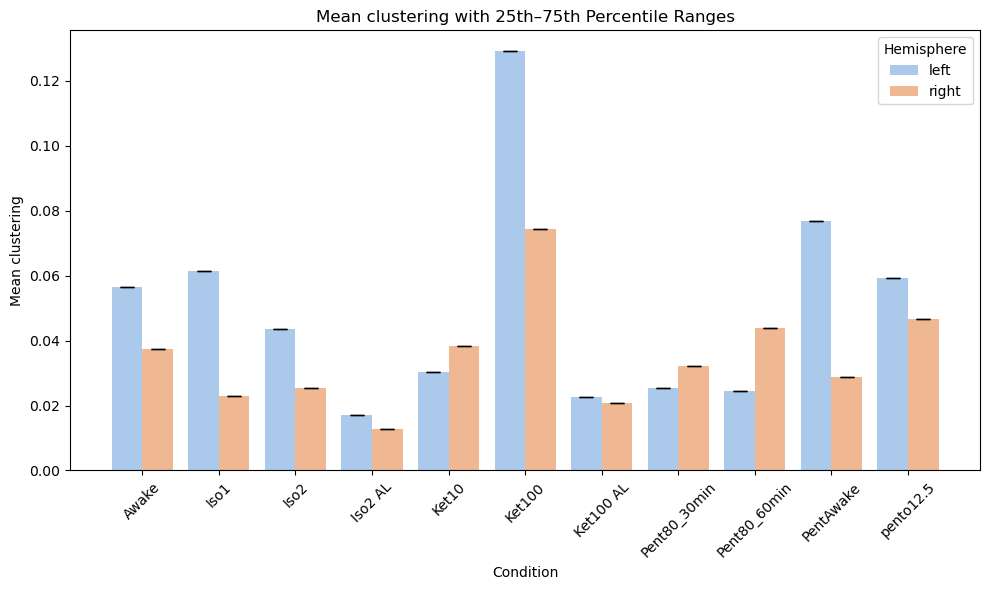

In [77]:
metric = 'clustering'

df = df.sort_values(['cond', 'hemi'])

# Create figure and axis
plt.figure(figsize=(10, 6))

# Make the barplot but disable CI/errorbars
barplot = sns.barplot(data=df, x='cond', y= metric + '_mean', hue='hemi', errorbar=None, palette='pastel')

# Add error bars manually
# Get the positions of the bars
x_coords = []
for bars in barplot.containers:
    for bar in bars:
        x = bar.get_x() + bar.get_width() / 2
        x_coords.append(x)
x_coords = np.sort(x_coords)


# Extract error values
yerr_lower = df[metric + '_std'].values
yerr_upper = df[metric + '_std'].values
yerr = [0*yerr_lower, 0*yerr_upper]


# Add error bars
plt.errorbar(x_coords, df[metric + '_mean'], yerr=yerr, fmt='none', ecolor='black', capsize=5)

# Final touches
plt.xlabel('Condition')
plt.ylabel('Mean ' + metric)
plt.title('Mean ' + metric + ' with 25th–75th Percentile Ranges')
plt.legend(title='Hemisphere')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


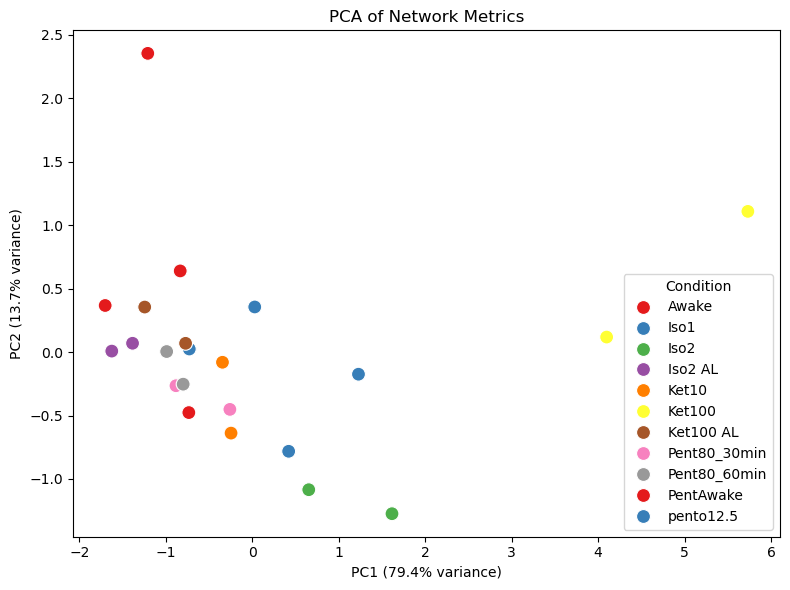

In [61]:
# Select the relevant columns for PCA
metrics = ['weight_mean', 'indeg_mean', 'betweeness_mean', 'clustering_mean']
X = df[metrics].values

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Add PCA results back to the DataFrame
df['PC1'] = X_pca[:, 0]
df['PC2'] = X_pca[:, 1]

# Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='PC1', y='PC2', hue='cond', palette='Set1', s=100)
plt.title('PCA of Network Metrics')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)')
plt.legend(title='Condition')
plt.tight_layout()
plt.show()

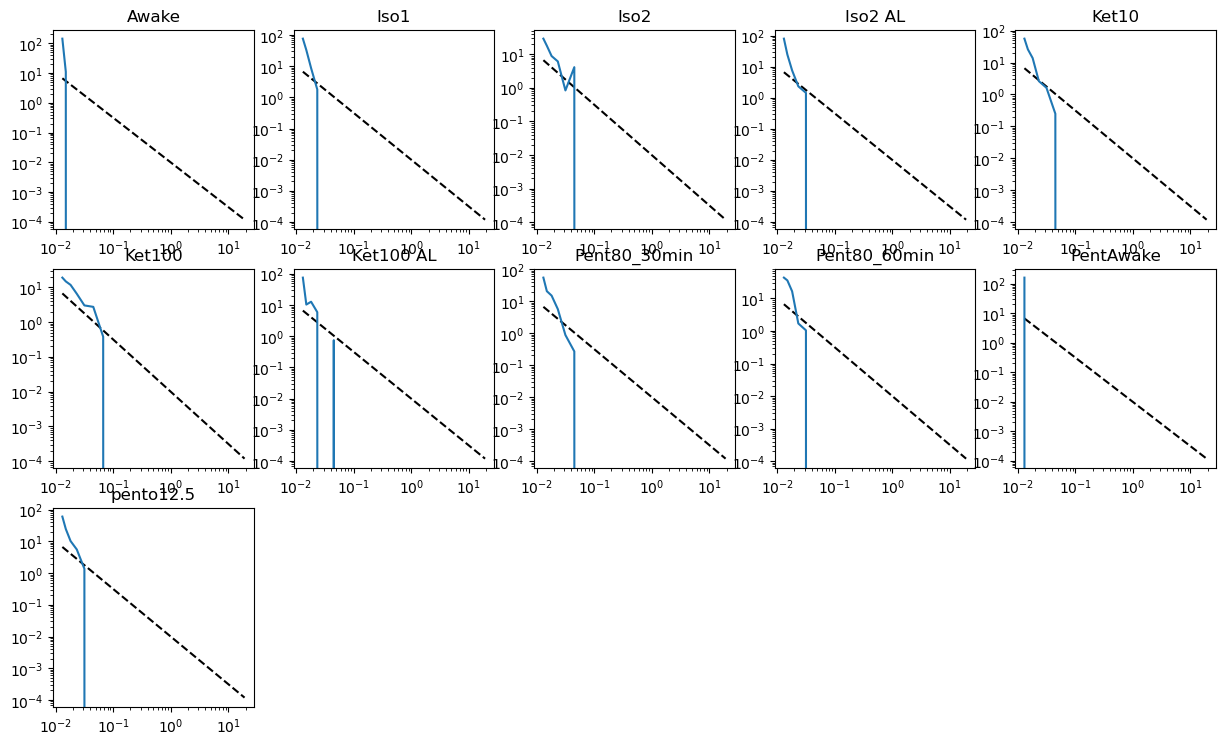

In [63]:
# plot degree distribution for each graph
bins = [10**x for x in np.linspace(-2,2,20)]
ncols = int(np.ceil(np.sqrt(len(df['keys']))))
nrows = int(np.ceil(np.sqrt(len(df['keys']))))

plt.figure(figsize=(3*ncols,3*nrows))
#for i,key in enumerate(df['keys']):
for i,key in enumerate(np.unique(df['cond'])):
    # Load the graph from the dictionary using its key
    G = avg_graphs[key +'/left']
    weights = nx.get_edge_attributes(G, 'weight')
    
    # Create a histogram of the edge weights
    plt.subplot(nrows,ncols,i+1)

    dat = list(weights.values())
    res = stats.ecdf(dat)
    
    n, bins = np.histogram(dat , bins = bins, density = True)
    c = bins[0::-2]+ np.diff(bins)/2
    plt.plot(c,0.01*c**-1.5, '--k')
    #plt.plot(res.cdf.quantiles, 1-res.cdf.probabilities)
    plt.plot(c, n)
    #plt.hist(weights.values(), bins=bins, density = True)
    plt.title(key)
    plt.yscale('log')
    plt.xscale('log')

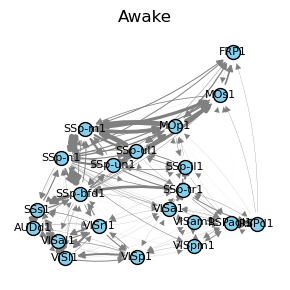

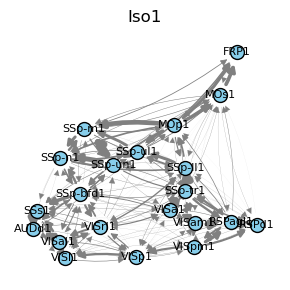

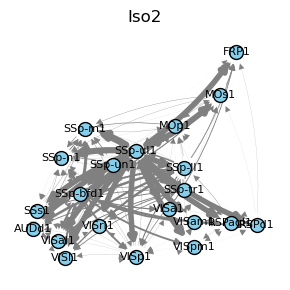

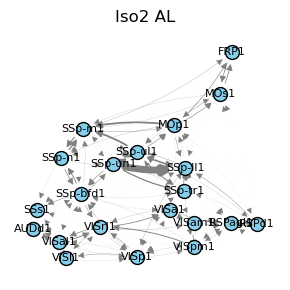

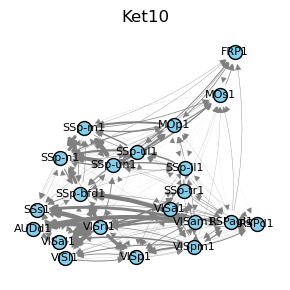

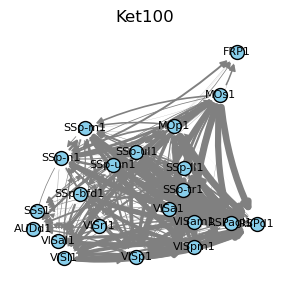

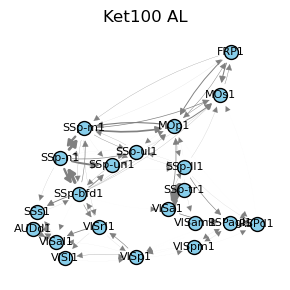

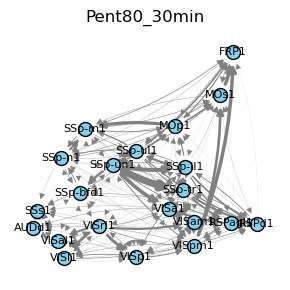

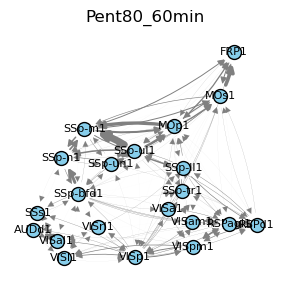

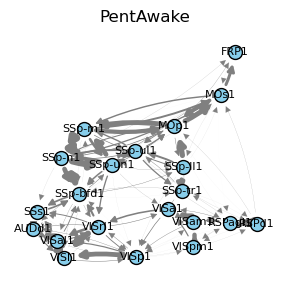

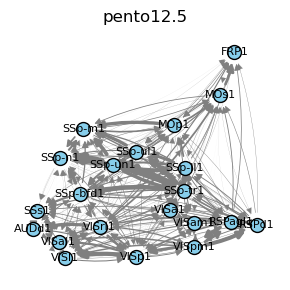

In [79]:
for key in np.unique(df['cond']):
    draw_weighted_graph(avg_graphs[key + '/left'], title = key)